In [69]:
import cv2
import matplotlib.pyplot as plt
import easyocr
import numpy as np
import tensorflow as tf

In [4]:
def crop_image(image, t, b, l, r):
  h, w = image.shape[:2]
  pt = int(h * t / 100.0)
  pb = int(h * b / 100.0)
  pl = int(w * l / 100.0)
  pr = int(w * r / 100.0)

  return image[pt:h - pb, pl:w - r]

In [ ]:
if not os.path.isfile('./model_resnet.tflite'):
    API_ENDPOINT = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?public_key={}'
    link_r = requests.get(API_ENDPOINT.format('https://disk.yandex.ru/d/QavLH1pvpRhLOA'))
    response= requests.get(link_r.json()['href'])
    if response.status_code == 200:
        with open("./model_resnet.tflite", 'wb') as f:
            f.write(response.content)

# Подготовка изображения

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


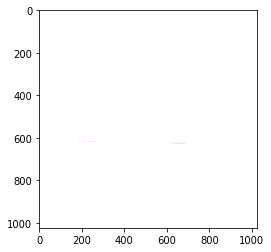

In [63]:
nn_path='./model_resnet.tflite'

#image = cv2.imread('auto/k204xx82.jpeg')
#image = cv2.imread('auto/b005bb777.jpg')
#image = cv2.imread('auto/x005ex777.jpg')
#image = cv2.imread('auto/a151aa177.jpg')
#image = cv2.imread('auto/p269em790.jpg')
image = cv2.imread('auto/a500aa99.jpg')


image_copy = image.copy()


image = cv2.resize(image, (1024,1024))
image = image.astype(np.float32)
X_data1=np.float32(image.reshape(1,1024, 1024,3))
plt.imshow(image)

# Подготовка нейросети

In [64]:
interpreter = tf.lite.Interpreter(model_path=nn_path)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

X_data1=np.float32(image.reshape(1,1024, 1024,3))

input_index = (interpreter.get_input_details()[0]['index'])
interpreter.set_tensor(input_details[0]['index'], X_data1)

## Выполнение и получение результата

In [65]:
interpreter.invoke()
detection = interpreter.get_tensor(output_details[0]['index'])

## Выделение номера на изображении

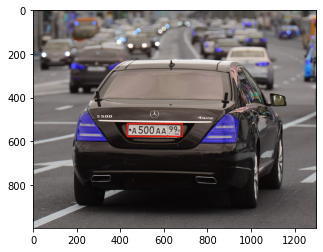

In [66]:
image_height, image_width, _ = image_copy.shape

x = int(detection[0,0,0] * image_height)
y = int(detection[0,0,1] * image_width)
w = int(detection[0,0,2] * image_height)
h = int(detection[0,0,3] * image_width)

cv2.rectangle(image_copy, (y, x), (h ,w), (230, 30, 21), thickness=5)
plt.imshow(image_copy)

## Подготовка изображения с номером

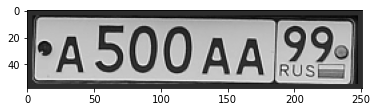

In [67]:
plate = image_copy[x:w,y:h,:]
plate = cv2.cvtColor(plate, cv2.COLOR_BGR2GRAY)
tplate = cv2.GaussianBlur(plate, (3,3), 0)
tplate = crop_image(tplate, 12, 12, 9, 8)

plt.imshow(plate, cmap='gray')

In [33]:
reader = easyocr.Reader(['en'], gpu=False) # загрузка OCR движка

Using CPU. Note: This module is much faster with a GPU.


## Распознавание

In [68]:
allow_chars = ['A', 'B', 'E', 'K', 'M', 'H', 'O', 'P', 'C', 'T', 'Y', 'X', '1','2','3','4','5','6','7','8','9','0']
result = reader.recognize(tplate, allowlist=allow_chars)
result[0][1]

'A500AA199H'